In [1]:

import time
import numpy as np
import matplotlib.pyplot as plt

#from env import SuikaEnv

%matplotlib inline

In [2]:
# スイカゲームプレイ用の環境
# Stateはcv2.VideoCapture(2)で取得した画像
# Actionは
import time

import cv2
import easyocr

from Commands.Keys import KeyPress, Button, Hat, Direction, Stick
from utils import Sender

COMPORT = 3
SCORE_XMIN, SCORE_YMIN, SCORE_XMAX, SCORE_YMAX = 150, 160, 400, 260
RING_EVOLUTION_XMIN, RING_EVOLUTION_YMIN, RING_EVOLUTION_XMAX, RING_EVOLUTION_YMAX = 1400, 500, 1850, 1000
RING_EVOLUTION_THRESHOLD = 400000000
RANKIN_TEXT_XMIN, RANKIN_TEXT_YMIN, RANKIN_TEXT_XMAX, RANKIN_TEXT_YMAX = 600, 200, 1300, 300
RANKIN_TEXT_XMIN_2, RANKIN_TEXT_YMIN_2, RANKIN_TEXT_XMAX_2, RANKIN_TEXT_YMAX_2 = 250, 150, 1100, 250
GAMEOVER_TEXT_XMIN, GAMEOVER_TEXT_YMIN, GAMEOVER_TEXT_XMAX, GAMEOVER_TEXT_YMAX = 400, 150, 1000, 220
RANKIN_THRESHOLD = 100000000
RANKIN_THRESHOLD_2 = 100000000
GAMEOVER_THRESHOLD = 100000000
INIT_TEXT_XMIN, INIT_TEXT_YMIN, INIT_TEXT_XMAX, INIT_TEXT_YMAX = 400, 320, 1500, 420
INIT_TEXT_THRESHOLD = 100000000
OBSERVE_XMIN, OBSERVE_YMIN, OBSERVE_XMAX, OBSERVE_YMAX = 550, 50, 1750, 1050
OBSERVE_SIZE = (120, 100)


class SuikaEnv:
    def __init__(self):

        self.rankin_text_image = cv2.imread("template_images/rankin_text_image.png")
        self.rankin_text_image_2 = cv2.imread("template_images/rankin_text_image_2.jpg")
        self.gameover_text_image = cv2.imread("template_images/gameover_text_image.png")
        self.init_text_image = cv2.imread("template_images/init_text_image.png")
        self.ring_evolution_image = cv2.imread("template_images/ring_evolution.jpg")
        self.rankin_text_image = self.rankin_text_image[:, :, ::-1]
        self.rankin_text_image_2 = self.rankin_text_image_2[:, :, ::-1]
        self.gameover_text_image = self.gameover_text_image[:, :, ::-1]
        self.init_text_image = self.init_text_image[:, :, ::-1]
        self.ring_evolution_image = self.ring_evolution_image[:, :, ::-1]
        self.reader = easyocr.Reader(['en'])
        self.current_score = 0
        ser = Sender(False)
        ser.openSerial(COMPORT)
        self.key = KeyPress(ser)

        self.cap = cv2.VideoCapture(2)
        self.cap.set(3, 1920)
        self.cap.set(4, 1080)
        self.reader = easyocr.Reader(['en'])
        self.current_score = 0

    
    def step(self, action):
        if action == 0:
            # Aを押す
            self.key.input([Button.A])
            time.sleep(0.1)
            self.key.inputEnd([Button.A])
            time.sleep(1)
        elif action == 1:
            # 左を押す
            self.key.input([Hat.LEFT])
            time.sleep(0.2)
            self.key.inputEnd([Hat.LEFT])
        elif action == 2:
            # 右を押す
            self.key.input([Hat.RIGHT])
            time.sleep(0.2)
            self.key.inputEnd([Hat.RIGHT])
        else:
            raise ValueError('action must be 0, 1 or 2')

        # 点数の取得
        score = self.get_score()
        if score >= 0:
            reward = score - self.current_score
            if 0 < reward < 500: # スイカゲームの仕様上1秒間に500点以上増えることは通常ない
                self.current_score = score
            else:
                reward = 0
        else:
            reward = 0
        
        # 終了判定を行う
        done = self.is_done()

        # 観測の取得
        obs = self.get_observation()
        return obs, reward, done

    def reset(self):
        # stateを初期化
        obs = self.get_observation()
        self.current_score = self.get_score()

        return obs
    
    def return_to_game(self):
        game_state = self.is_which_state()

        while game_state != "Playing":
            if game_state == "Rankin":
                # Aを押して1秒待機
                self.key.input([Button.A])
                time.sleep(0.1)
                self.key.inputEnd([Button.A])
                time.sleep(2)
                # 左を押す
                self.key.input([Hat.LEFT])
                time.sleep(0.2)
                self.key.inputEnd([Hat.LEFT])
                # Aを押す
                self.key.input([Button.A])
                time.sleep(0.1)
                self.key.inputEnd([Button.A])
                time.sleep(3)
            elif game_state == "Rankin_2":
                self.key.input([Button.A])
                time.sleep(0.1)
                self.key.inputEnd([Button.A])
                time.sleep(2)
                # 左を押す
                self.key.input([Hat.LEFT])
                time.sleep(0.2)
                self.key.inputEnd([Hat.LEFT])
                # Aを押す
                self.key.input([Button.A])
                time.sleep(0.1)
                self.key.inputEnd([Button.A])
                time.sleep(3)
            elif game_state == "Gameover":
                # 左を押す
                self.key.input([Hat.LEFT])
                time.sleep(1)
                self.key.inputEnd([Hat.LEFT])
                # Aを押す
                self.key.input([Button.A])
                time.sleep(0.1)
                self.key.inputEnd([Button.A])
                time.sleep(3)
            elif game_state == "Init":
                self.key.input([Button.L, Button.R])
                time.sleep(6)
                self.key.inputEnd([Button.L, Button.R])
                self.key.input([Button.A])
                time.sleep(0.1)
                self.key.inputEnd([Button.A])
                self.key.input([Button.A])
                time.sleep(0.1)
                self.key.inputEnd([Button.A])
                self.key.input([Button.A])
                time.sleep(0.1)
                self.key.inputEnd([Button.A])
                time.sleep(3)
            time.sleep(1)
            frame = self.get_frame() # get_frame()を空打ちしないと取得できるカメラ画像が更新されていないことがある（？）
            game_state = self.is_which_state()
    
    def is_done(self):
        # 現在の画面が状態かを判定するメソッド
        frame = self.get_frame()
        # 通常のプレイ画面かどうかの判定
        res = cv2.matchTemplate(
             frame[RING_EVOLUTION_YMIN:RING_EVOLUTION_YMAX, RING_EVOLUTION_XMIN:RING_EVOLUTION_XMAX, :], 
             self.ring_evolution_image, 
             cv2.TM_CCOEFF
        )
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        if max_val > RING_EVOLUTION_THRESHOLD:
            return False
        else:
            return True
    
    def is_which_state(self):
        # 現在の画面が状態かを判定するメソッド
        frame = self.get_frame()
        # 通常のプレイ画面かどうかの判定
        res = cv2.matchTemplate(
             frame[RING_EVOLUTION_YMIN:RING_EVOLUTION_YMAX, RING_EVOLUTION_XMIN:RING_EVOLUTION_XMAX, :], 
             self.ring_evolution_image, 
             cv2.TM_CCOEFF
        )
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        if max_val > RING_EVOLUTION_THRESHOLD:
            return "Playing"

        # ランキングイン画面かどうかの判定
        res = cv2.matchTemplate(
             frame[RANKIN_TEXT_YMIN:RANKIN_TEXT_YMAX, RANKIN_TEXT_XMIN:RANKIN_TEXT_XMAX, :], 
             self.rankin_text_image, 
             cv2.TM_CCOEFF
        )
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        if max_val > RANKIN_THRESHOLD:
            return "Rankin"
        
        # もう一つのランキングイン画面かどうかの判定
        res = cv2.matchTemplate(
             frame[RANKIN_TEXT_YMIN_2:RANKIN_TEXT_YMAX_2, RANKIN_TEXT_XMIN_2:RANKIN_TEXT_XMAX_2, :],
             self.rankin_text_image_2, 
             cv2.TM_CCOEFF
        )
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        if max_val > RANKIN_THRESHOLD_2:
            return "Rankin_2"

        # ゲームオーバー画面かどうかの判定
        res = cv2.matchTemplate(
             frame[GAMEOVER_TEXT_YMIN:GAMEOVER_TEXT_YMAX, GAMEOVER_TEXT_XMIN:GAMEOVER_TEXT_XMAX, :], 
             self.gameover_text_image, 
             cv2.TM_CCOEFF
        )
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        if max_val > GAMEOVER_THRESHOLD:
            return "Gameover"
        
        res = cv2.matchTemplate(
                frame, 
                self.init_text_image, 
                cv2.TM_CCOEFF
            )
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        if max_val > INIT_TEXT_THRESHOLD:
            return "Init"

        return None
    
    def get_score(self):
        # 現在のスコアを取得するメソッド
        frame = self.get_frame()
        score_image = frame[SCORE_YMIN:SCORE_YMAX, SCORE_XMIN:SCORE_XMAX, :]
        text = self.reader.readtext(score_image)
        try:
            score = int(text[0][1])
        except:
            score = -1
        return score

    def get_frame(self, discard_frame=1):
        for _ in range(discard_frame):
            self.cap.read()
        # 現在のフレームを取得するメソッド
        ret, frame = self.cap.read()
        if not ret:
            raise ValueError('frame is None')
        frame = frame[:, :, ::-1]
        return frame
    
    def get_observation(self):
        frame = self.get_frame()
        obs = frame[OBSERVE_YMIN:OBSERVE_YMAX, OBSERVE_XMIN:OBSERVE_XMAX, :]
        obs = cv2.resize(obs, OBSERVE_SIZE, interpolation=cv2.INTER_LINEAR)
        return obs




In [3]:
class RandomAgent:
    def __init__(self):
        self.probs = [0.8, 0.1, 0.1]
        self.actions = np.arange(3)

    def act(self, obs):
        return np.random.choice(self.actions, p=self.probs)

    

In [4]:
agent = RandomAgent()

In [5]:
env = SuikaEnv()
done = False
env.return_to_game()
obs = env.reset()

episodes = []
for _ in range(30):
    steps = 0
    total_return = 0
    episode = []
    while True:
        action = agent.act(obs)
        next_obs, reward, done = env.step(action)
        total_return += reward
        episode.append((obs, action, reward, next_obs, done))
        if done:
            print(f"total return: {total_return}, steps: {steps}")
            print("\n\n\n\=========================done===================================\n\n\n")
            done = False
            steps = 0
            break
        steps += 1
        obs = next_obs
    episodes.append(episode)
    time.sleep(5)
    env.return_to_game()
    obs = env.reset()

connecting to COM3
Playing
total return: 709, steps: 126



\=========================done===================================



Gameover
Playing
total return: 1165, steps: 174



\=========================done===================================



Rankin
Playing
total return: 1058, steps: 160



\=========================done===================================



Rankin
Playing
total return: 953, steps: 150



\=========================done===================================



Gameover
Playing
total return: 993, steps: 167



\=========================done===================================



Gameover
Playing
total return: 621, steps: 131



\=========================done===================================



Gameover
Playing
total return: 600, steps: 122



\=========================done===================================



Gameover
Playing
total return: 867, steps: 167



\=========================done===================================



Gameover
Playing
total return: 963, step

In [6]:
print(len(episodes))

30


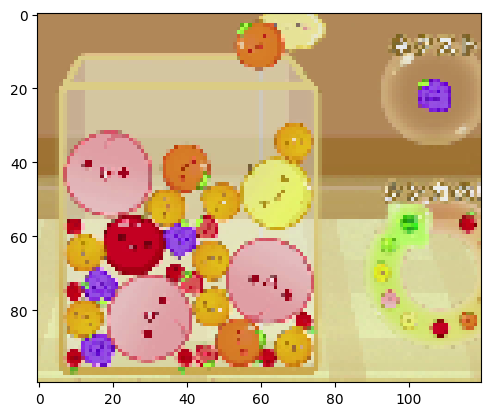

In [7]:
episode = episodes[0]
obs, action, reward, next_obs, done = episode[100]
plt.imshow(obs)
plt.show()

In [8]:
import pickle
with open('episodes.pkl', 'wb') as f:
    pickle.dump(episodes, f)

# 読み込みチェック
with open('episodes.pkl', 'rb') as f:
    episodes = pickle.load(f)

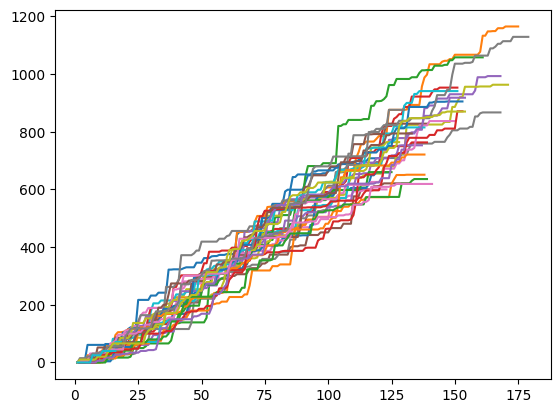

In [9]:
for episode in episodes:
    total_return = 0
    steps = 0
    return_list = []
    steps_list = []
    for obs, action, reward, next_obs, done in episode:
        total_return += reward
        steps += 1
        return_list.append(total_return)
        steps_list.append(steps)
    plt.plot(steps_list, return_list)
plt.show()